
# Optimal power flow model in Julia

In [ ]:
import Pkg

# activate parent environment
Pkg.activate(normpath(joinpath(@__DIR__, ".")))
Pkg.resolve()
Pkg.instantiate()
Pkg.status()

using CSV
using DataFrames
using Dates
using TimeZones
using CairoMakie
using JuMP
import JSON
import MathOptInterface as MOI

using Revise
using OptHP

  Activating project at `c:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort`
  No Changes to `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Project.toml`
  No Changes to `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Manifest.toml`


Status `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Project.toml`
  [336ed68f] CSV v0.10.15
  [13f3f980] CairoMakie v0.13.1
  [a93c6f00] DataFrames v1.7.0
  [682c06a0] JSON v0.21.4
  [4076af6c] JuMP v1.23.6
  [b8f27783] MathOptInterface v1.35.1
  [2d871509] OptHP v1.0.0-DEV `OptHP`
⌃ [295af30f] Revise v3.7.1
  [f269a46b] TimeZones v1.20.0
  [ade2ca70] Dates
Info Packages marked with ⌃ have new versions available and may be upgradable.


## Load power / user data

In [149]:
network = CSV.read("data/network.csv", DataFrame)
network.R = network.R ./ Z_base
network.X = network.X ./ Z_base
first(network, 5)

Row,StartNode,EndNode,Length,cable,Inom,R,X
,Int64,Int64,Float64,String7,Float64,Float64,Float64
1,47,15,22.21,50Al,0.12528,0.00269123,0.000356871
2,49,40,15.57,95Al,0.18386,0.000941853,0.00024135
3,26,41,18.26,95Al,0.18386,0.00110457,0.000283047
4,11,12,6.71,95Al,0.18386,0.000405898,0.000104011
5,12,27,6.52,95Al,0.18386,0.000394405,0.000101066


In [150]:
connections = CSV.read("data/user_connect.csv", DataFrame; delim=";")

# convert PV (str) to Float64
connections.PV = parse.(Float64, replace.(connections.PV, "," => "."))

first(connections, 5)

Row,Column1,Name,Node.ID,Node.Unom,Length,Type short,Connection value,load,PV,HP,Node
,Int64,Int64,Int64,Int64,String7,String15,String7,Int64,Float64,Int64,Int64
1,1,871694840006284337,46559968,230,"21,75",XLPE 4x6Cu,3x25 A,7000,4.0,1,50
2,2,871694840006288793,46563894,230,"2,22",XLPE 4x6Cu,3x25 A,7000,6.0,0,51
3,3,871694840006284108,11195660,230,"10,4",PVC 4x16Al,1x35 A,2000,2.2,0,52
4,4,871694840006284115,11195660,230,"10,4",PVC 4x16Al,1x35 A,500,2.2,0,53
5,5,871694840006284092,2573422,230,"7,33",PVC 4x16Al,1x35 A,2000,2.2,0,54


In [151]:
# define date to use for filtering
date = Date(2024, 2, 1)

# load data
path = "data/H14/H14_usage_return.csv"
loads = CSV.read(path, DataFrame)
loads.timestamp = DateTime.(loads.timestamp, "yyyy-mm-dd HH:MM:SS")
loads = loads[:, 2:3]

# we rescale usage_total_kW to usage_total_W to p.u.: 1E3 .* usage_total_kW / S_base
loads.usage_total_pu = 1E3 .* loads.usage_total_kW ./ S_base
select!(loads, Not(:usage_total_kW))

first(loads, 5)

Row,timestamp,usage_total_pu
,DateTime,Float64
1,2024-01-17T23:00:00,0.0
2,2024-01-17T23:15:00,0.00112
3,2024-01-17T23:30:00,0.00121333
4,2024-01-17T23:45:00,0.00146667
5,2024-01-18T00:00:00,0.00123556


## Read weather data

In [152]:
weather_df = CSV.read("data/weather/weather.csv", DataFrame)
select!(weather_df, Not([:interpolated]))
rename!(weather_df, Dict("P_solar" => "Φ_s", "T_ambient" => "T_a"))

dt_format = "yyyy-mm-ddTHH:MM:SS.sss+zzzz"
weather_df.timestamp = DateTime.(ZonedDateTime.(String.(weather_df.timestamp), dt_format))
weather_df = interpolate_data(weather_df, 15)

# select a particular day (Defined in date above)
# weather_df = weather_df[Date.(weather_df.timestamp) .== date, :]

# add electricity price [€/kWh]
weather_df.λ_e .= 0.21

# convert Φ_s from W to kW
weather_df.Φ_s .= weather_df.Φ_s ./ 1000

println("Weather data shape: ", size(weather_df))
first(weather_df, 5)

Interpolating columns: [:Φ_s, :T_a]
Weather data shape: (27169, 4)


Row,timestamp,Φ_s,T_a,λ_e
,DateTime,Float64,Float64,Float64
1,2023-09-01T00:00:00,0.0,9.5,0.21
2,2023-09-01T00:15:00,0.0,9.45,0.21
3,2023-09-01T00:30:00,0.0,9.6,0.21
4,2023-09-01T00:45:00,0.0,9.5,0.21
5,2023-09-01T01:00:00,0.0,9.6,0.21


## Merge data and display

In [153]:
df_full = innerjoin(weather_df, loads, on = :timestamp);

In [154]:
# select a particular day (Defined by date)
date = Date(2024, 3, 2)

df = df_full[Date.(df_full.timestamp) .== date, :]
first(df, 5)

Row,timestamp,Φ_s,T_a,λ_e,usage_total_pu
,DateTime,Float64,Float64,Float64,Float64
1,2024-03-02T00:00:00,0.0,7.5,0.21,0.000142222
2,2024-03-02T00:15:00,0.0,7.45,0.21,0.000248889
3,2024-03-02T00:30:00,0.0,7.6,0.21,0.000173333
4,2024-03-02T00:45:00,0.0,7.5,0.21,0.000142222
5,2024-03-02T01:00:00,0.0,7.4,0.21,0.000146667


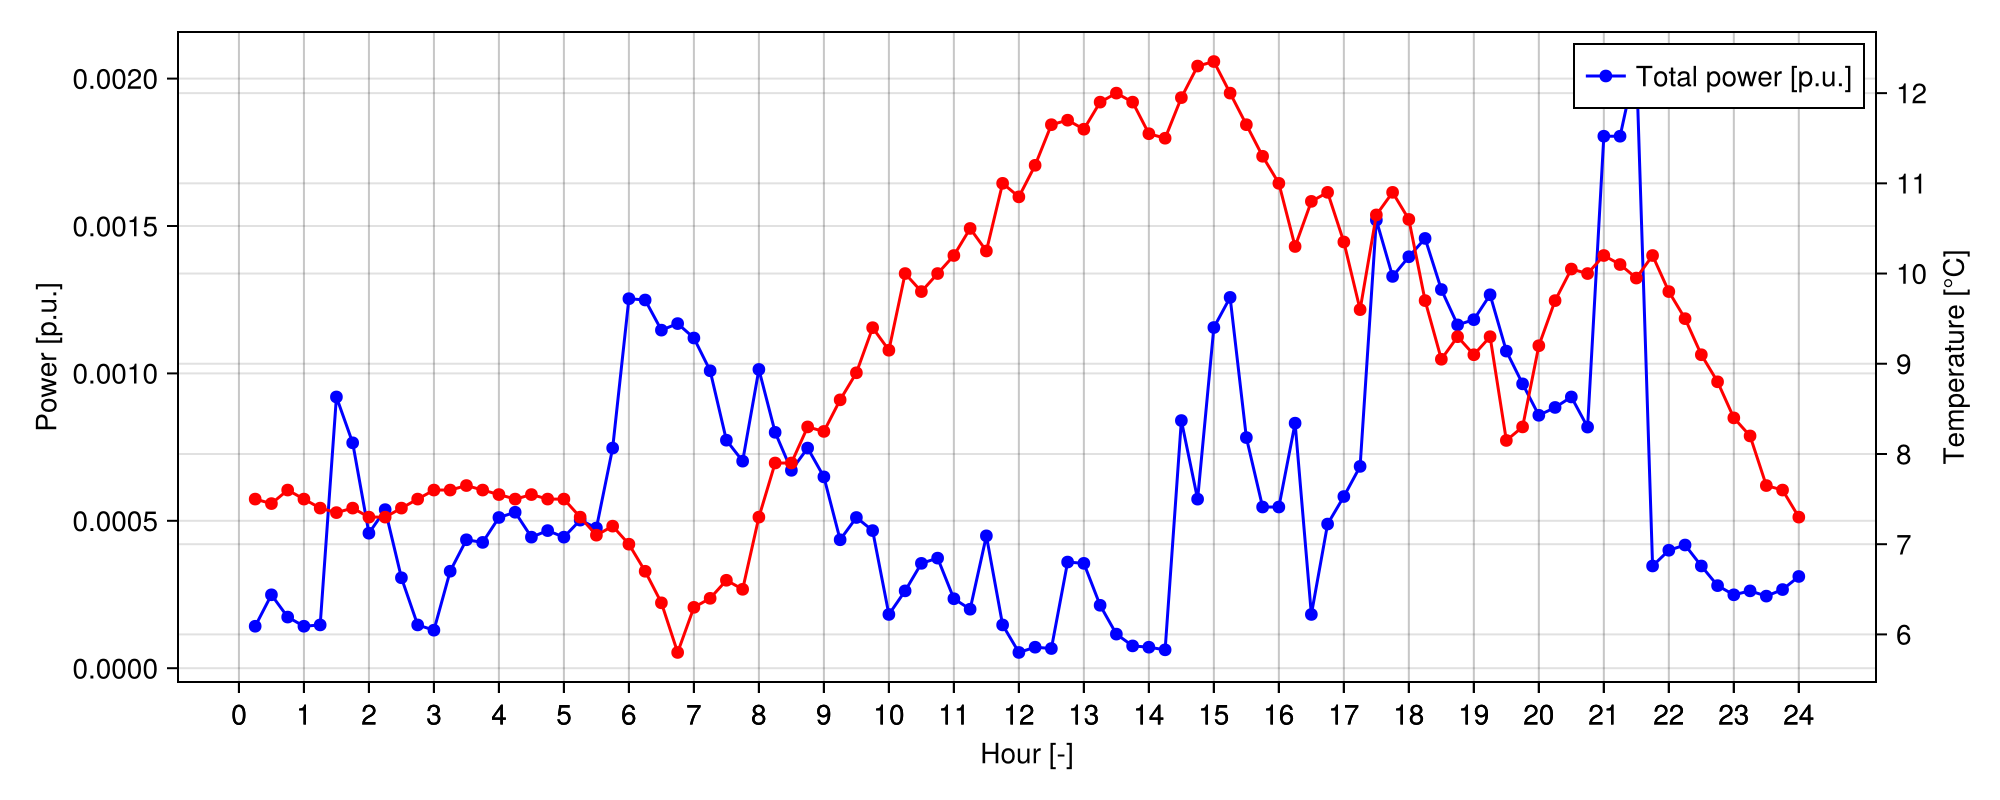

In [155]:
# plot user power data
fig = Figure(; size = (1000, 400))

ax_power = Axis(fig[1, 1], xlabel="Hour [-]", ylabel="Power [p.u.]", xticks=(0:4:96, string.(0:1:24)))
ax_temp = Axis(fig[1, 1], ylabel="Temperature [°C]", xticks=(0:4:96, string.(0:1:24)), yaxisposition = :right)

scatterlines!(ax_power, df.usage_total_pu, label="Total power [p.u.]", color=:blue)
scatterlines!(ax_temp, df.T_a, label="Temperature", color=:red)
axislegend(ax_power)
fig

## Load state-space matrices

In [156]:
id = "H14"

A_d = Matrix(CSV.read("data/$(id)/$(id)_15min_A_exact.csv", DataFrame))
B_d = Matrix(CSV.read("data/$(id)/$(id)_15min_B_exact.csv", DataFrame))

H14_meta = Dict(
    "A" => A_d,
    "B" => B_d
)

meta = Dict(
    "H14" => H14_meta
)

Dict{String, Dict{String, Matrix{Float64}}} with 1 entry:
  "H14" => Dict("B"=>[0.00663784 0.00224598 0.166439; 9.37536e-5 2.65051e-6 0.0…

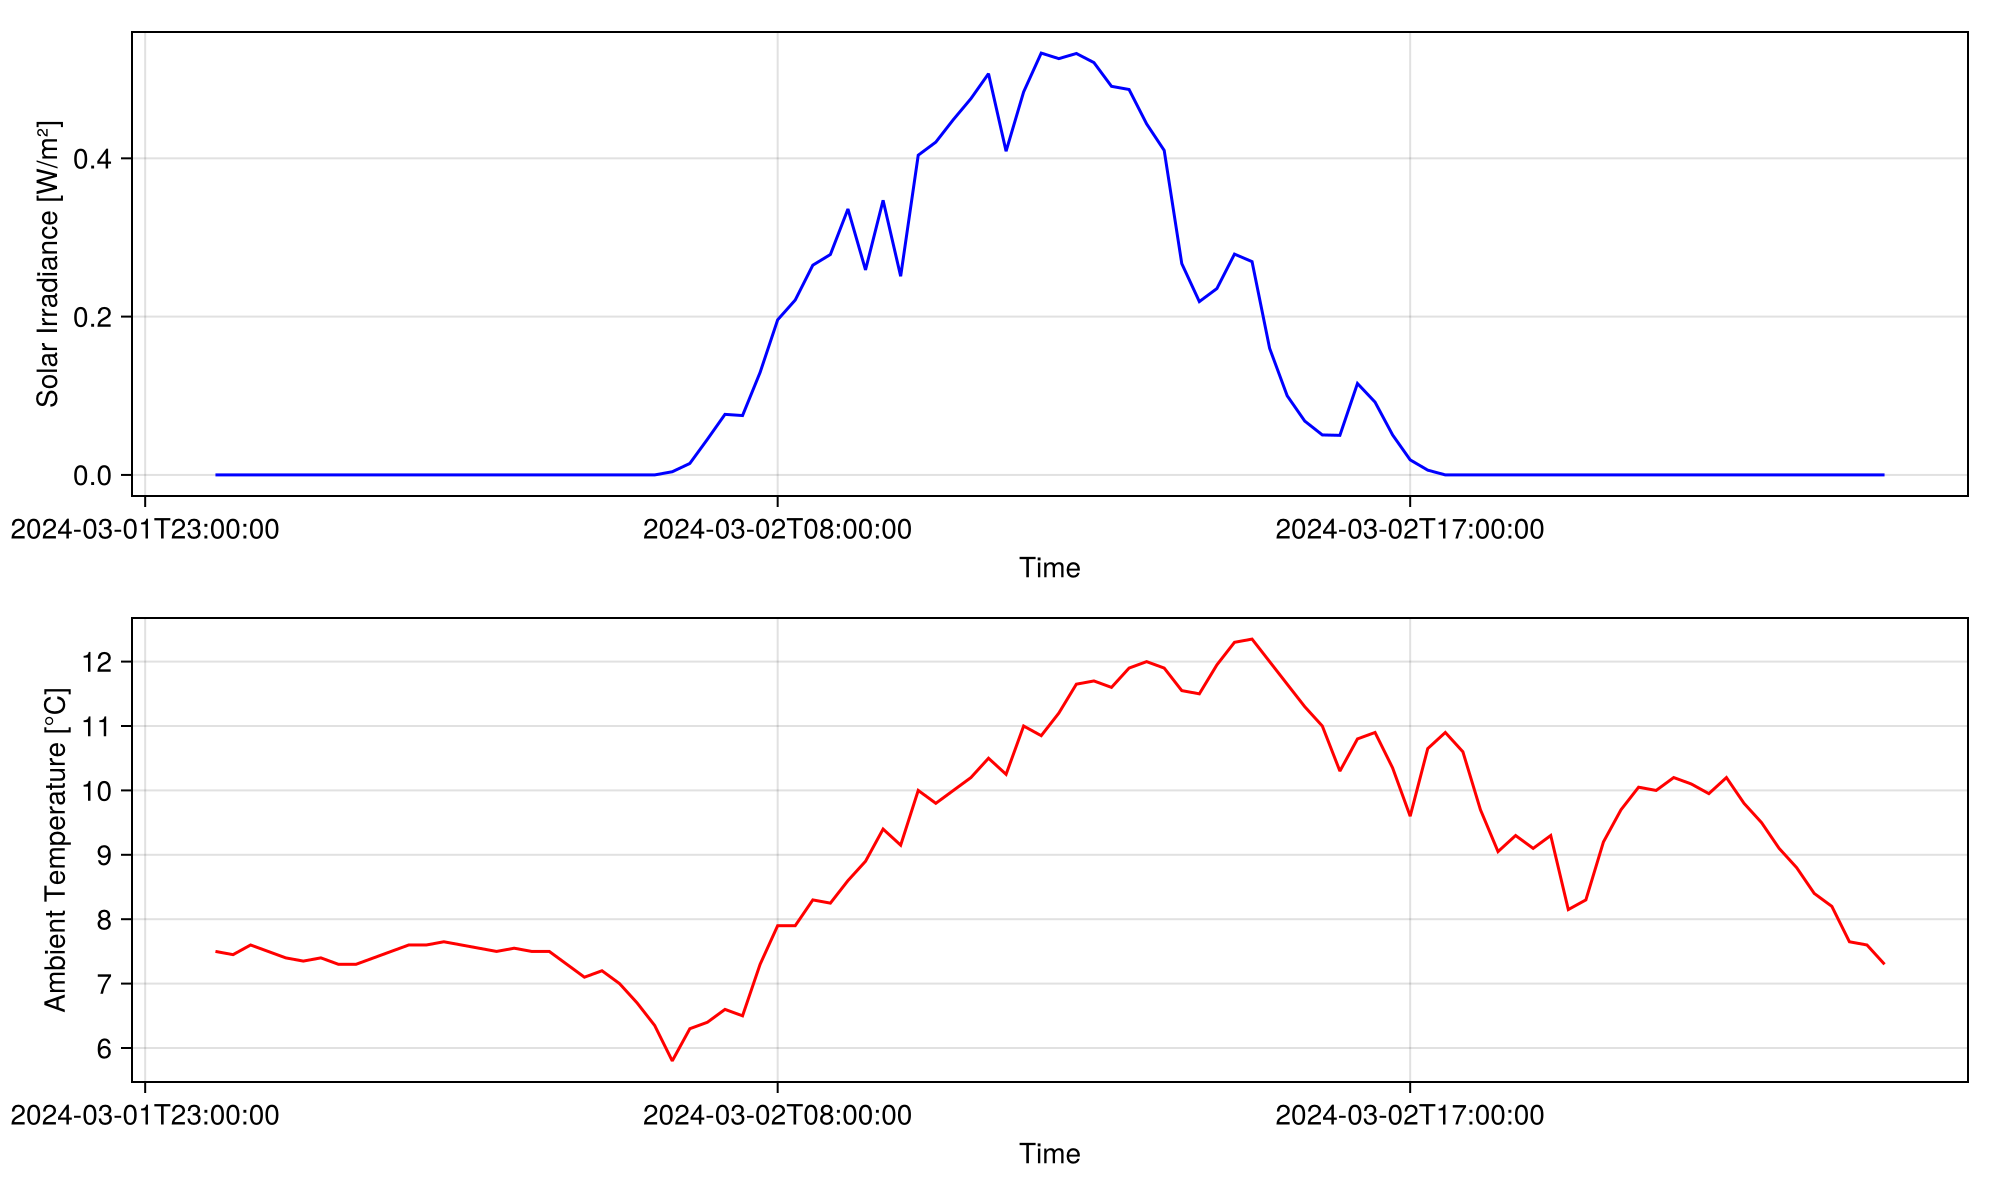

In [157]:
# plot the weather data
fig = Figure(; size = (1000, 600))

ax1 = Axis(fig[1, 1], xlabel="Time", ylabel="Solar Irradiance [W/m²]")
ax2 = Axis(fig[2, 1], xlabel="Time", ylabel="Ambient Temperature [°C]")

lines!(ax1, DateTime.(df.timestamp), df.Φ_s, color=:blue)
lines!(ax2, DateTime.(df.timestamp), df.T_a, color=:red)
fig

## Grid model with test data

In [158]:
# # test network with 4 buses 
# #       0   (slack)
# #       |
# #       1   (junction)
# #      / \
# #     2   3 (loads)

# network_test = DataFrame(
#     StartNode = [0, 1, 1],
#     EndNode = [1, 2, 3],
#     Length = [1.0, 1.0, 1.0],
#     Inom = [0.1, 0.1, 0.1],
#     R = [0.1, 0.1, 0.1],
#     X = [0.01, 0.01, 0.01]
# )

# # correct R, X using Z_base
# network_test.R = network_test.R ./ Z_base
# network_test.X = network_test.X ./ Z_base

# # grid connections
# connections_test = DataFrame(
#     HP = [0, 0],
#     Node = [2, 3]
# )

# # loads real 
# N = 96
# df_test = DataFrame(
#     Symbol("usage_total_pu") => df.usage_total_pu[1:N],
# )
# first(df_test, 5)

In [159]:
# model = GEC(network=network_test, 
#             connections=connections_test, 
#             df=df_test,
#             meta = meta,
#             silent=false,
#             T=1:N,
#             limit=(1:N, 1E6),
# )

In [160]:
# primal_feasibility_report(model, atol=1E-5)

## Construct GEC

In [161]:
T=1:96

1:96

In [162]:
model = GEC(network=network, 
            connections=connections,
            df=df,
            meta = meta,
            silent=false,
            limit=(T, 250 * 1e6),
            T=T
)

Set parameter Username
Set parameter LicenseID to value 2599292
Academic license - for non-commercial use only - expires 2025-12-13
Set parameter LogFile to value "my_log_file.txt"
Set parameter LogFile to value "my_log_file.txt"
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 9 5950X 16-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 78048 rows, 82848 columns and 210144 nonzeros
Model fingerprint: 0x131e2491
Model has 8256 quadratic constraints
Coefficient statistics:
  Matrix range     [4e-09, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [9e-01, 1e+00]
  RHS range        [5e-05, 1e+04]
Presolve removed 41664 rows and 36960 columns
Presolve time: 0.09s
Presolved: 36384 rows, 45888 columns, 130752 nonzeros
Presolved model has 8256 second-order cone constraints
Ordering time: 0.01s



A JuMP Model
├ solver: Gurobi
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 49824
├ num_constraints: 78240
│ ├ AffExpr in MOI.EqualTo{Float64}: 36768
│ ├ AffExpr in MOI.LessThan{Float64}: 8256
│ ├ Vector{AffExpr} in MOI.SecondOrderCone: 8256
│ ├ VariableRef in MOI.GreaterThan{Float64}: 16608
│ └ VariableRef in MOI.LessThan{Float64}: 8352
└ Names registered in the model
  └ :ConicOPF, :I_line, :J_gen, :J_loss, :LineCurrentLimit, :P, :P_line, :Q, :Q_line, :ReactiveBaseLoad, :ReactivePowerBalance, :RealBaseLoad, :RealPowerBalance, :Transmission, :VoltageDrop, :v

## Test some outputs

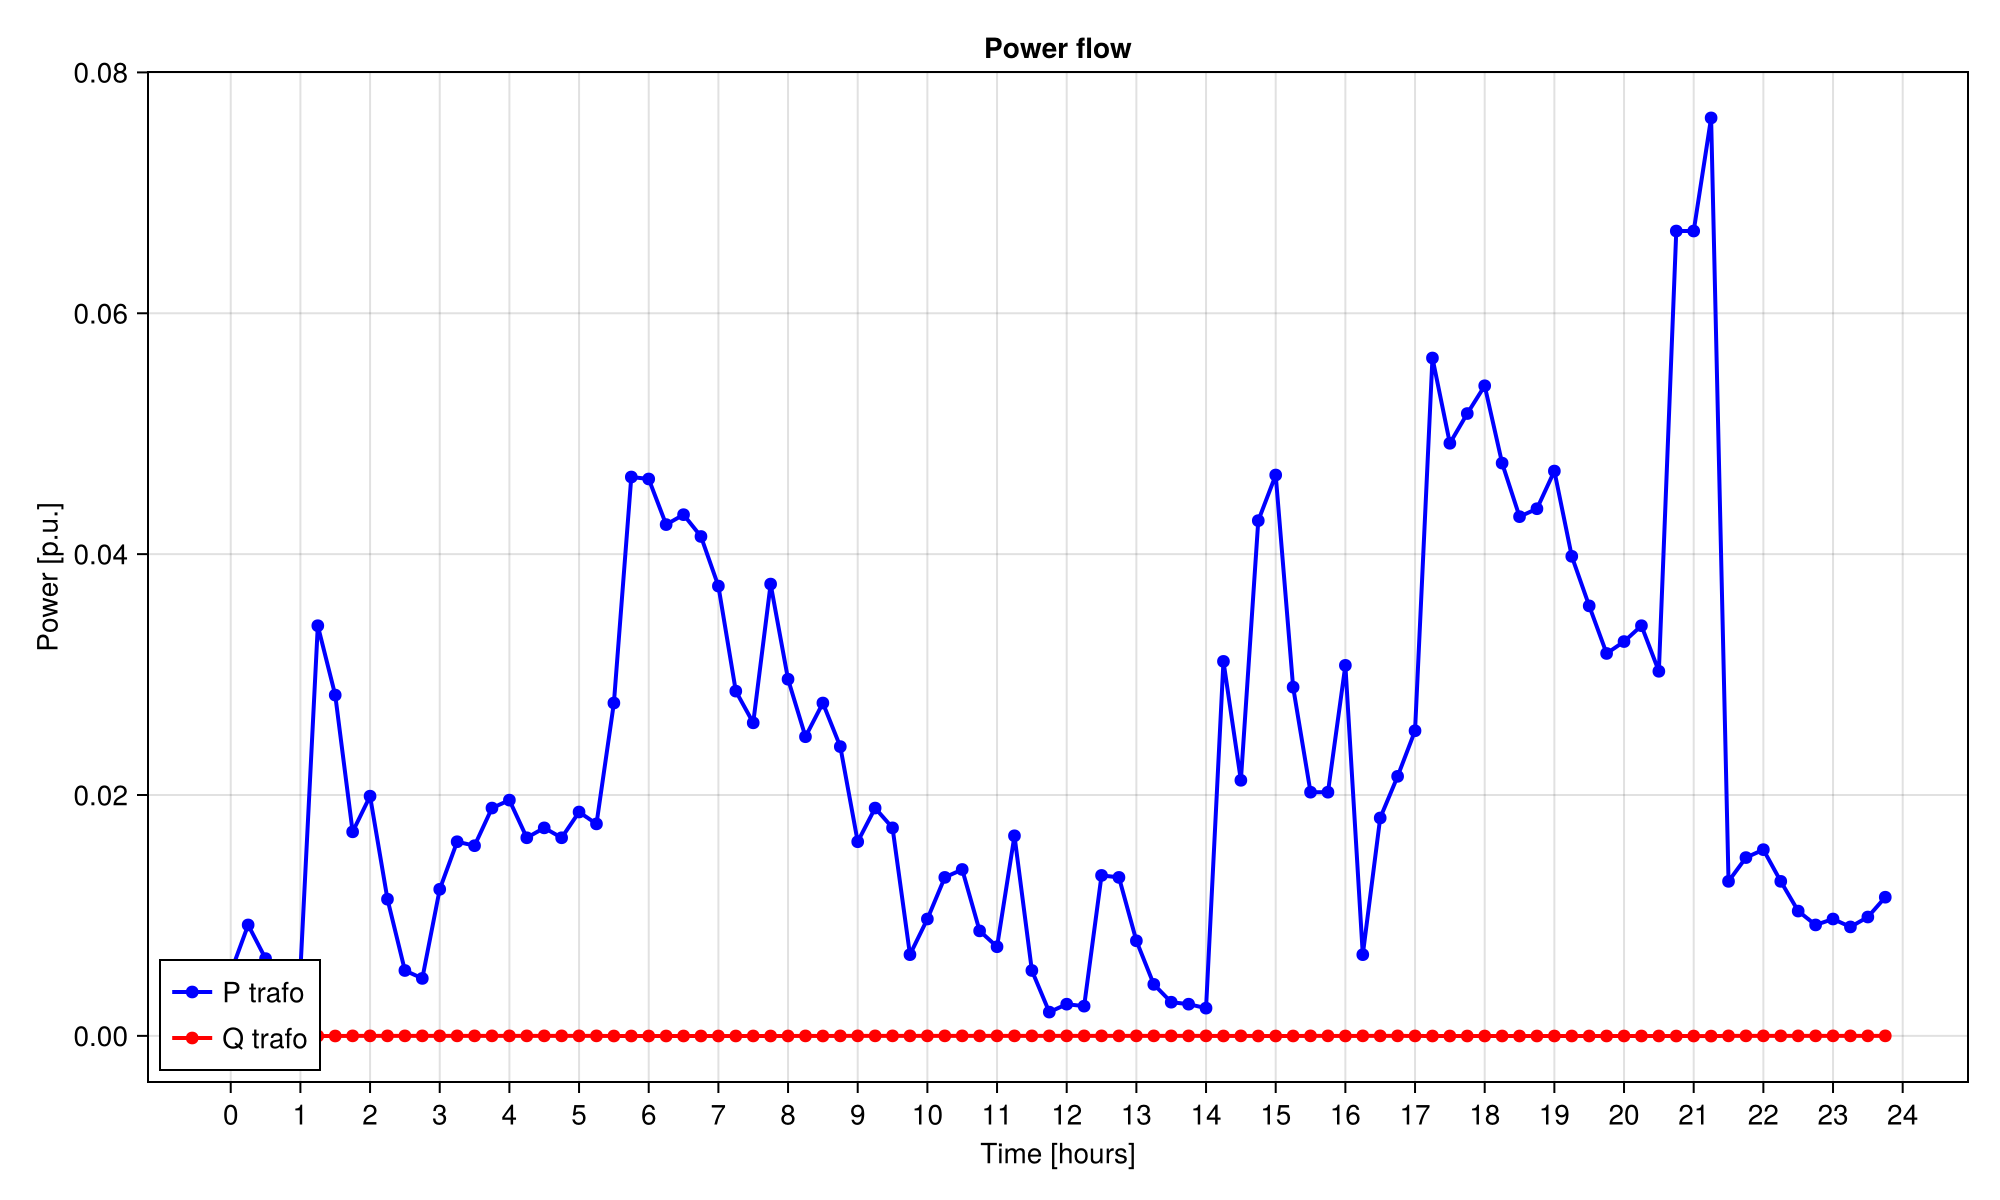

In [163]:
# plot using Makie
fig = Figure(; size = (1000, 600))
ax = Axis(fig[1, 1], xlabel = "Time [hours]", 
    ylabel = "Power [p.u.]", 
    title = "Power flow",
    xticks = (1:4:97, string.(0:1:24))
)

# index of slack bus (transformer)
# SB = argmin(value.(model[:P]).axes[2])
bus = 55
P_trafo = Matrix(value.(model[:P]))[bus,:]
Q_trafo = Matrix(value.(model[:Q]))[bus,:]


# lines!(ax, sol[:P], color = :blue, label = "Transformer", linestyle = :so
scatterlines!(ax, P_trafo, color = :blue, label = "P trafo", linewidth = 2)
scatterlines!(ax, Q_trafo, color = :red, label = "Q trafo", linewidth = 2)
axislegend(ax, position = :lb)

# display
fig


Line 34 -> 0
Line 2 -> 74


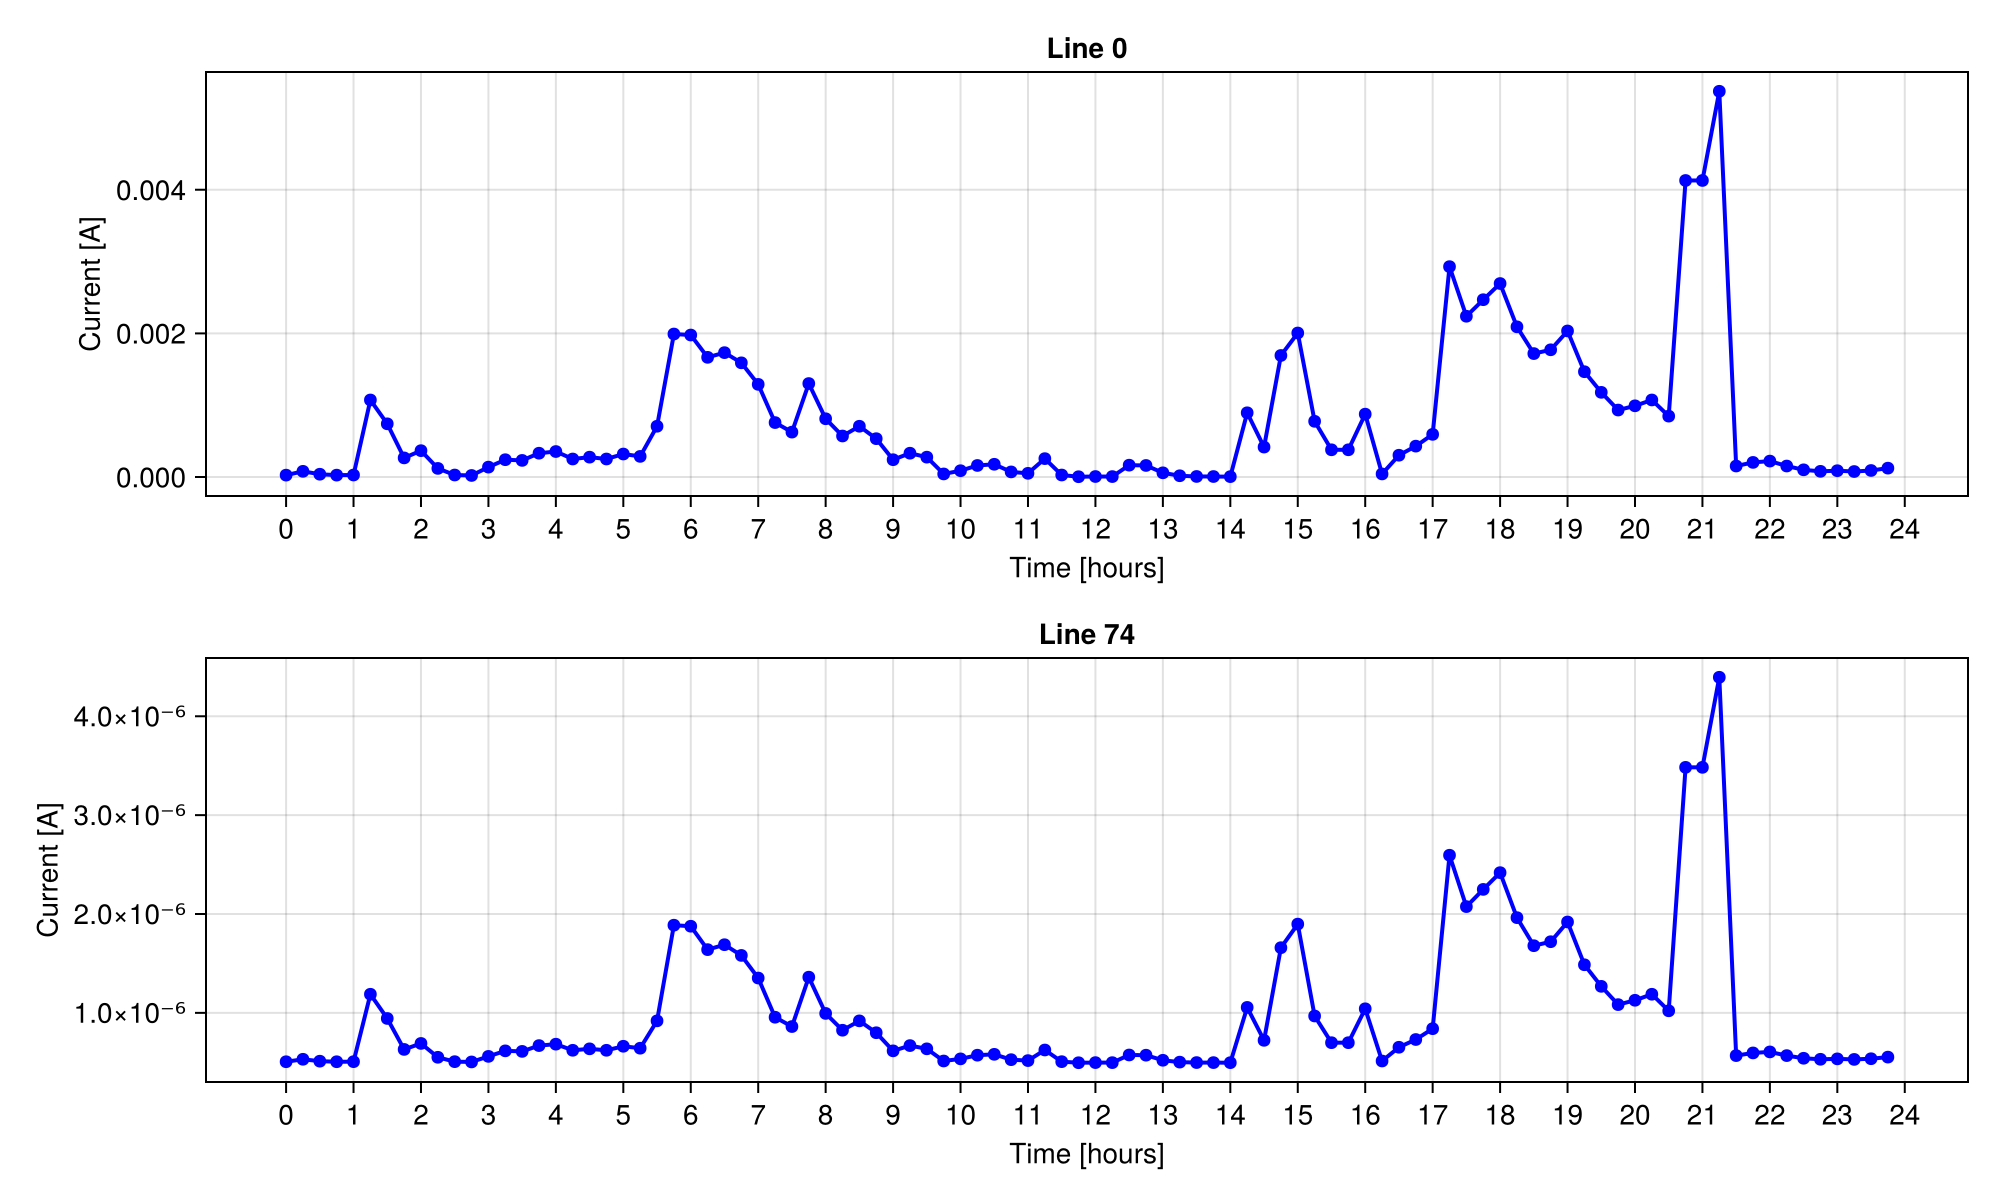

In [164]:
# line currents 
fig = Figure(; size = (1000, 600))

I_line = value.(model[:I_line])
# for (i,j) in [(1, 2), (0, 1), (1, 3)]
for (idx,(i,j)) in enumerate([(34, 0), (2, 74)])
    println("Line $i -> $j")
    ax = Axis(fig[idx, 1], xlabel = "Time [hours]", 
        ylabel = "Current [A]", 
        title = "Line $j",
        xticks = (1:4:97, string.(0:1:24))
    )
    scatterlines!(ax, Vector(I_line[(i,j),:]), color = :blue, label = "I line $j", linewidth = 2)
end

fig


In [165]:
termination_status(model)

OPTIMAL::TerminationStatusCode = 1

In [166]:
println(objective_value(model))
println(objective_bound(model))
println(dual_objective_value(model))

2.227518220104159
2.2275155450767685
2.2275155450767685


In [167]:
primal_feasibility_report(model; atol = 1E-5)

Dict{Any, Float64}()

In [168]:
open("solution.sol", "w") do io
    for var in all_variables(model)
        println(io, "$(var) = $(value.(var))")
    end
end